# Music Genre Classification

With the help of Neural Networks , this Notebook classifies music genres. This is the second approach using **Convolutional Neural Network**

In [2]:
import os
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from google.colab import drive
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

drive.mount('/content/drive')

Mounted at /content/drive


# Step 1

Load data from Google Drive and transform labels from strings to integers from 0 to 3, keeping their mapping to class names. Then load the data into Dataloaders.

In [3]:
location = r'/content/drive/My Drive/data_music/'

train_path = location + 'train/melgrams/'
train_x = np.load(train_path + 'X.npy')
train_lbls = np.load(train_path + 'labels.npy')

test_path = location + 'test/melgrams/'
test_x = np.load(test_path + 'X.npy')
test_lbls = np.load(test_path + 'labels.npy')

val_path = location + 'val/melgrams/'
val_x = np.load(val_path + 'X.npy')
val_lbls = np.load(val_path + 'labels.npy')



* mel-spectrograms (melgrams) are used in this approach. MelGrams being 2D time-frequency representations, resemble images and thus naturally align with CNNs.



In [4]:
class melgramData(Dataset): #use opposite labels
  def __init__(self,data, labels,labels_map,transform=None, target_transform=None) -> None:
    self.transform = transform
    self.target_transform = target_transform
    self.melgramlabels = []
    for l in labels:
      self.melgramlabels.append(labels_map[l])
    self.melgramlabels = np.array(self.melgramlabels)
    self.melgramdata = data

  def __len__(self):
    return len(self.melgramlabels)

  def __getitem__(self, index):
    sound = self.melgramdata[index]
    label = self.melgramlabels[index]
    if self.transform:
      sound = self.transform(sound)
    if self.target_transform:
      label = self.target_transform(label)

    return sound, label

In [5]:
labels_map = {
    0: "classical",
    1: "blues",
    2: "rock_metal_hardrock",
    3: "hiphop",
}

inverse_labels_map = {
    'classical' : 0,
    'blues' : 1,
    'rock_metal_hardrock' : 2,
    'hiphop' : 3,
}

train_data = melgramData(train_x, train_lbls, inverse_labels_map, torch.tensor)
val_data = melgramData(val_x, val_lbls, inverse_labels_map, torch.tensor)
test_data = melgramData(test_x, test_lbls, inverse_labels_map, torch.tensor)

train_dataloader = DataLoader(train_data, batch_size=16,shuffle=True )
val_dataloader =  DataLoader(val_data, batch_size=16 ,shuffle=True )
test_dataloader =  DataLoader(test_data, batch_size=16 ,shuffle=False )

In [12]:
labelsMapping, indexed_labels_train = np.unique(train_lbls, return_inverse=True)
labelsMapping, indexed_labels_val = np.unique(val_lbls, return_inverse=True)
labelsMapping, indexed_labels_test = np.unique(test_lbls, return_inverse=True)

* Visualizemelgrams from each set.

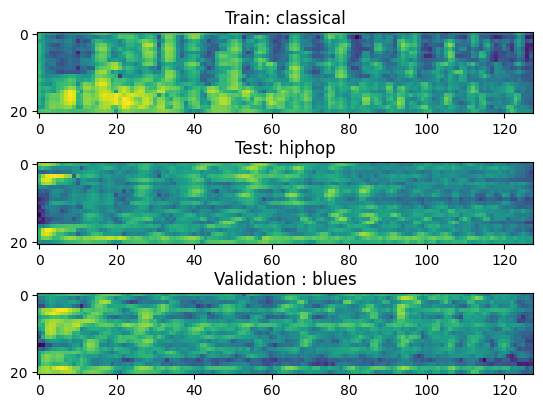

In [6]:
#Sample Visualization
sample = np.random.randint(len(train_data), size=(1,)).item()
img, label = train_data[sample]
plt.subplot(3,1,1)
plt.title('Train: ' + labels_map[label])
plt.imshow(img.squeeze())

sample = np.random.randint(len(val_data), size=(1,)).item()
img, label = val_data[sample]
plt.subplot(3,1,3)
plt.title('Validation : ' + labels_map[label])
plt.imshow(img.squeeze())

sample = np.random.randint(len(test_data), size=(1,)).item()
img, label = test_data[sample]
plt.subplot(3,1,2)
plt.title('Test: ' + labels_map[label])
plt.imshow(img.squeeze())

# STEP 2

Vanilla Convolutional Neural Network.

In [7]:
class LeNet(nn.Module):
  def __init__(self) -> None:
      super(LeNet, self).__init__()
      self.convolution_layer = nn.Sequential(
          nn.Conv2d(1, 16, 5),
          nn.Conv2d(16, 32, 5),
          nn.Conv2d(32, 64, 5),
          nn.Conv2d(64, 128, 5),
      )

      self.linear_relu_stack = nn.Sequential(
          nn.Linear(71680, 1024),
          nn.Linear(1024, 256),
          nn.Linear(256,32),
          nn.Linear(32,4),
      )

  def forward(self, x):
    x = self.convolution_layer(x)
    x = torch.flatten(x,1)
    logits =  self.linear_relu_stack(x)
    return logits




*   Training Function



In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  device = 'cpu'
  for batch, (X, y) in enumerate(dataloader):

        X = X.to(device)
        y = y.to(device)
        X = torch.unsqueeze(X,1)

# Compute prediction and loss
        pred = model(X) #For each input batch  #forward()
        loss = loss_fn(pred, y) #Compute loss

# Backpropagation
        optimizer.zero_grad() ##find gradients
        loss.backward()  ##bacvk propagate loss
        optimizer.step() ##optimization

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

* Evaluation Function

In [9]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [17]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    device = 'cpu'

#The no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    predictions = []
    labels = []
    with torch.no_grad():
        for X, y in dataloader:
#If using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)
            X = torch.unsqueeze(X,1)

            pred = model(X)
            predictions.append(pred.argmax(1).cpu().numpy())
            labels.append(y.cpu().numpy())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
#np.array to use with  scikit
    predictions = np.array(predictions).flatten()
    labels = np.array(labels).flatten()
    # print(f'The sape of the labels {labels.shape} and of the Predictions {predictions.shape}')
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} , Accuracy: {accuracy} , f1_macro: {f1_macro} \n")
    return test_loss , accuracy , f1_macro , labels , predictions

* Train and Evaluate Function

In [11]:
def train_with_validation(epochs, optimizer, tr_dataloader, val_dataloader, loss_fn , model):
  opt_model = None
  opt_f1 = 0
  opt_epoch = 0
  for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    train_loop(tr_dataloader, model, loss_fn, optimizer)
    loss , acc , f1 , true , pred = test_loop(val_dataloader ,model ,loss_fn)
    if f1 > opt_f1:
      opt_model = model
      opt_f1 = f1
      opt_epoch = e
  print(f'Best Epoch is : {opt_epoch} with {opt_f1} f1_score')
  return opt_model

In [13]:
def confusionMatrix(trues, preds):
    names =[labelsMapping[0], labelsMapping[1], labelsMapping[2],labelsMapping[3]]
    cfmatr = confusion_matrix(trues, preds)
    df_cm = pd.DataFrame(cfmatr/np.sum(cfmatr) * 4, index = [i for i in names],
                     columns = [i for i in names])
    plt.figure(figsize = (9,9))
    sns.heatmap(df_cm, cmap='viridis_r', annot=True)
    plt.show()

#Step 3

Train

In [14]:
def training_fun(Network):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  c_model = LeNet().to(device)
  # print(c_model)
  learning_rate = 0.002
  optimizer = torch.optim.SGD(c_model.parameters(), lr = learning_rate)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 30

  start_time = time.time()
  for t in range(num_epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loop(train_dataloader, c_model, loss_fn, optimizer)

  loss , acc , f1 , true , pred = test_loop(test_dataloader, c_model, loss_fn)
  confusionMatrix(true, pred)
  print("Done!")
  print(f'\n Time needed: {time.time() - start_time}')

In [ ]:
training_fun(LeNet)

The training procedure is really slow and the loss infinity. This brings us to the need of the next step.

# Step 4

Pooling and Padding.
Pooling is useful because it reduces the dimensions of the feature map, so it makes the representations smaller and easier to use. After Padding , the size of the output is smaller than the input.

In [20]:
class LeNet(nn.Module):
  def __init__(self) -> None:
      super(LeNet, self).__init__()
      self.convolution_layer = nn.Sequential(
          nn.Conv2d(1, 16, 5, stride=1, padding=2),
          nn.MaxPool2d(2),
          nn.Conv2d(16, 32, 5, stride=1, padding=2),
          nn.MaxPool2d(2),
          nn.Conv2d(32, 64, 5, stride=1, padding=2),
          nn.MaxPool2d(2),
          nn.Conv2d(64, 128, 5, stride=1, padding=2),
          nn.MaxPool2d(2),
      )

      self.linear_relu_stack = nn.Sequential(
          nn.Linear(1024, 1024),
          nn.Linear(1024, 256),
          nn.Linear(256,32),
          nn.Linear(32,4),
      )

  def forward(self, x):
    x = self.convolution_layer(x)
    x = torch.flatten(x,1)
    logits =  self.linear_relu_stack(x)
    return logits

In [ ]:
training_fun(LeNet)

# Step 5

Activation Functions

In [ ]:
class LeNet(nn.Module):
  def __init__(self) -> None:
      super(LeNet, self).__init__()
      self.convolution_layer = nn.Sequential(
          nn.Conv2d(1, 16, 5, stride=1, padding=2),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Conv2d(16, 32, 5, stride=1, padding=2),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Conv2d(32, 64, 5, stride=1, padding=2),
          nn.ReLU(),
          nn.MaxPool2d(2),
          nn.Conv2d(64, 128, 5, stride=1, padding=2),
          nn.ReLU(),
          nn.MaxPool2d(2),
      )

      self.linear_relu_stack = nn.Sequential(
          nn.Linear(1024, 1024),
          nn.ReLU(),
          nn.Linear(1024, 256),
          nn.ReLU(),
          nn.Linear(256,32),
          nn.ReLU(),
          nn.Linear(32,4),
      )

  def forward(self, x):
    x = self.convolution_layer(x)
    x = torch.flatten(x,1)
    logits =  self.linear_relu_stack(x)
    return logits

In [ ]:
training_fun(LeNet)